In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
print(torch.__version__)

2.5.1+cu121


In [ ]:
# create device agnosticism, but preferably should run on cuda
# I am working with Colab Pro Regular, and will be using the Tesla A100
primary_device = "cuda" if torch.cuda.is_available() else "cpu"
primary_device, torch.cuda.device_count()

('cpu', 0)

In [ ]:
# data has been normalized, flattened to two dimensions, and shuffled to make it ready for the ML model
# I WANTED to use the largest size data I have, which splits the population into data points of 250 people.
# however, that leads to 1,300,000 entries. The runtime was unbelievable because my implementation is seemingly rudimentary, and I can't find a way to parallelize the k-means cluster averaging with any built in methods
# I don't want to use someone else's implementation of k-means, so i'll be using the 2500 per data set, but if you would like to use a larger size they are available here if you copy them into the data_filename:
# cont-us-pop-flattened-250per-shuffled.csv
# cont-us-pop-flattened-500per-shuffled.csv
# cont-us-pop-flattened-1000per-shuffled.csv
data_filename = 'cont-us-pop-flattened-2500per-shuffled.csv'

# I am hosting the data on my personal site
data_url = 'https://www.tyro.work/' + data_filename
data_local_path = '/content/' + data_filename
# use bash command on colab to get the data from the url
if not os.path.exists(data_local_path):
  !wget $data_url
else:
  print("Flattened Population Data has already been downloaded.")

--2024-11-25 06:49:07--  https://www.tyro.work/cont-us-pop-flattened-2500per-shuffled.csv
Resolving www.tyro.work (www.tyro.work)... 162.244.93.7, 2602:faa9:1008:918:fd16:9073:7cff:b175
Connecting to www.tyro.work (www.tyro.work)|162.244.93.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5751943 (5.5M) [text/csv]
Saving to: ‘cont-us-pop-flattened-2500per-shuffled.csv’

cont-us-pop-flatten 100%[===================>]   5.49M  4.67MB/s    in 1.2s    

2024-11-25 06:49:10 (4.67 MB/s) - ‘cont-us-pop-flattened-2500per-shuffled.csv’ saved [5751943/5751943]



In [ ]:
""" Here I wanted to create an example to demonstrate how the torch.cdist works.
cdist is how we're going to be calculating our distance and is going to be the crux of our k-means algorithm
we have two 2d tensors, but I wasn't sure whether to organize them as shape [2, x] or [x, 2] where x is the number of samples
we need to shape our tensors to match how this function works
"""
import math

x = torch.tensor([[1, 2], [3, 4], [6,9], [420, 69]], dtype=torch.float64)
y = torch.tensor([[5, 6], [7, 8], [6,9]], dtype=torch.float64)

manual_calc = math.sqrt((5 - 6) ** 2 + (6 - 9) ** 2)
print('manual calculation of euclidian distance: ', manual_calc) # taking x[2] and y[0]
dist = torch.cdist(x, y, p=2)  # p=2 for Euclidean distance
print(dist, dist.shape) # you can see that x[2], y[0] matches with dist[2][0]
print('cdist calculation: ', dist[2][0].item(), 'matches: ', dist[2][0].item() == manual_calc)


manual calculation of euclidian distance:  3.1622776601683795
tensor([[  5.6569,   8.4853,   8.6023],
        [  2.8284,   5.6569,   5.8310],
        [  3.1623,   1.4142,   0.0000],
        [419.7547, 417.4805, 418.3252]], dtype=torch.float64) torch.Size([4, 3])
cdist calculation:  3.1622776601683795 matches:  True


as you can see, the examples are organized by [x, 2] so that's how we will shape our tensors


what that means for us is that when we get our data we want to take the vector of longitudes (x axis) and vector of latitudes (y axis). Importing them from pandas will create a list of values which will create a [1,x] shape tensor.

So that means we need to reshape the two rows of lat and lng values into shape (-1, 1) so that they're stacked on top of each other.

When we have a vertical stack of values, then we can hstack the two tensors to combine them into a tensor of [[lng, lat], [lng, lat], ...]

In [ ]:
# use pandas to access the csv we downloaded and turn it into PyTorch tensor
data_frame = pd.read_csv(data_local_path)
# convert data frame into a tensor
lat_tensor = torch.tensor(data_frame['lat'].values)
lat_tensor = lat_tensor.reshape(-1, 1)
lng_tensor = torch.tensor(data_frame['lng'].values)
lng_tensor = lng_tensor.reshape(-1, 1)
# CAREFUL - latitude is how far up and down so it's y axis, lng is left right and it's x axis
lnglat_tensor = torch.hstack((lng_tensor, lat_tensor))
lnglat_tensor, lnglat_tensor.shape, lnglat_tensor[0], lnglat_tensor[:, 0], lnglat_tensor[:, 1]

(tensor([[ -4.6438,  -7.6205],
         [ 17.6918,   2.4979],
         [ 15.4640,   4.7245],
         ...,
         [-28.3583,  -3.6084],
         [  3.0228,  -7.7388],
         [ -3.1637,   0.6025]], dtype=torch.float64),
 torch.Size([131562, 2]),
 tensor([-4.6438, -7.6205], dtype=torch.float64),
 tensor([ -4.6438,  17.6918,  15.4640,  ..., -28.3583,   3.0228,  -3.1637],
        dtype=torch.float64),
 tensor([-7.6205,  2.4979,  4.7245,  ..., -3.6084, -7.7388,  0.6025],
        dtype=torch.float64))

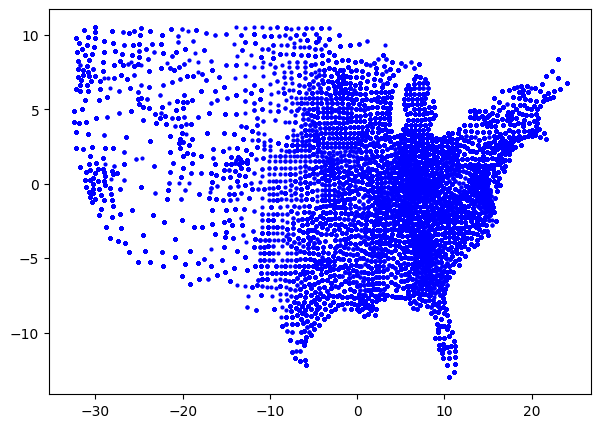

In [ ]:
# let's create a plotting device for our data points
def plot_inputs(input_tensor):
  plt.figure(figsize = (7,5))
  plt.scatter(input_tensor[:, 0], input_tensor[:, 1], c='b', s=4, label='data points')

plot_inputs(lnglat_tensor)

County Location Data has already been downloaded.
county data shape:  torch.Size([3109, 2])
county data:  tensor([[-26.5661,  -3.9594],
        [  3.8418,   3.5588],
        [ -3.7352,  -8.4235],
        ...,
        [ -8.5972,  -4.6648],
        [ -6.0431, -11.3528],
        [-11.9214,  -6.4320]], dtype=torch.float64)


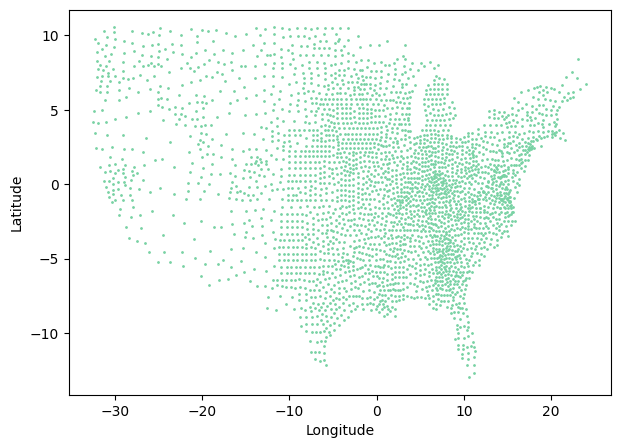

In [ ]:
# perfect. so that is great to see that it's working, but we don't need to draw all 1,300,000 points overtop of each other just to show the map.
# so let's import the unflattened data just to display everything with less draw time

# repeat the same steps we did before to format the data
drawing_data = 'https://www.tyro.work/cont-us-counties-latlng-normalized.csv'
if not os.path.exists('/content/cont-us-counties-latlng-normalized.csv'):
  !wget $drawing_data
else:
  print("County Location Data has already been downloaded.")

drawing_df = pd.read_csv('/content/cont-us-counties-latlng-normalized.csv')
draw_lat_tensor = torch.tensor(drawing_df['lat'].values)
draw_lat_tensor = draw_lat_tensor.reshape(-1, 1)
draw_lng_tensor = torch.tensor(drawing_df['lng'].values)
draw_lng_tensor = draw_lng_tensor.reshape(-1, 1)
# i thought we needed to vstack these, but we actually need hstack
draw_lnglat_tensor = torch.hstack((draw_lng_tensor, draw_lat_tensor))
print("county data shape: ", draw_lnglat_tensor.shape)
print('county data: ', draw_lnglat_tensor)
# these constants will be useful for randomizing our centroids
lat_max = draw_lat_tensor.max().item()
lat_min = draw_lat_tensor.min().item()
lng_max = draw_lng_tensor.max().item()
lng_min = draw_lng_tensor.min().item()

def draw_counties():
  plt.figure(figsize = (7,5))
  plt.scatter(draw_lnglat_tensor[:, 0], draw_lnglat_tensor[:, 1], c='#79d2a4', marker='.', s=4, label='U.S. Counties')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')

# now we have a method to quickly draw the county locations
draw_counties()

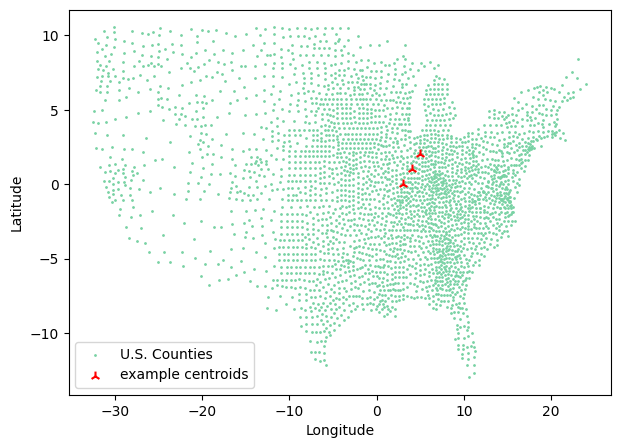

In [ ]:
x = [0, 1, 2]
y = [3, 4, 5]
draw_counties()
plot2 = plt.scatter(x, y, c='r', s=50, marker='2', label='example centroids')
plot3 = plt.scatter(y, x, c='r', s=50, marker='2', label='example centroids')
plt.legend()

plot2.remove()
del plot2
plt.legend()
# just an example of checking to see how our centroids will look over top of the county data
# with an example testing how the clf function works
# using remove and del instead

In [ ]:
# loss function
def find_closest_centroids_and_loss(X, centroids):
  """ compute the centorid memberships for each example
  we need to return two tensors:
    one that will return the indices of the centroid closest to each example
    one that will contain all of the loss for each example (min_dist by euclidian distance)
  """
  # cdist(X, centroids) produces a tensor where each row represents an input X, and each y is the euclidian distance to the centroid there
  euclidian_dist_to_centroids = torch.cdist(X, centroids, p=2)
  # rather than using .min and then .argmin to get the min and argmin, you can use a dimension argument in min to get both at the same time
  min_dist, argmin_indices = torch.min(euclidian_dist_to_centroids, dim=1)
  return (argmin_indices, min_dist)

In [ ]:
# now it's time to set up our k-means
# we want to pick the number of starting centroids (k), I believe that's our only input variable
LAT_RANGE = lat_max - lat_min + 1
LNG_RANGE = lng_max - lng_min + 1
LAT_SHIFT = lat_min # the shifts are negative values, so add them not subtract
LNG_SHIFT = lng_min
# print(LAT_RANGE, LNG_RANGE, LAT_SHIFT, LNG_SHIFT)
US_COUNTIES = 3109 # there are 3109 counties listed in our data of the continental united states.

# what do we need to save to display at the end when this is all done?
# for our analysis, what we NEED is the lowest cost for each k, and the final centroid locations after performing k-means
# furthermore from that I would also like to know 1. which seed produced that, 2. original centroid positions, 3. final loss for other seeds, 4. final centroid count
# so we'll track all of those values.

# you cannot use cdist on an empty tensor so k_means(0) does not work, but I want the index number to correlate with the k directly for later
# I've initialized these values with garbage data at the 0th index so that everything syncs
k_best_seeds = [0]
k_losses = [0]
k_best_init_centroids = [0]
k_best_final_centroids = [0]
k_all_seeds_resulting_loss = [0]
k_best_centroid_count = [0]

# finally, we need to split our data into a training set and a testing set
# I want to use 100000 data points for my model just because it's a cool number. it's about 76% of the dataset. So if you're using the larger training sets I'm setting it up to use 75% for data and 25% for testing
test_split = 100000 if data_filename == 'cont-us-pop-flattened-2500per-shuffled.csv' else (len(lnglat_tensor[0]) * 3) // 4
training_set = lnglat_tensor[:test_split, :]
testing_set = lnglat_tensor[test_split:, :]
# print(training_set.shape, testing_set.shape, training_set, testing_set)
N = training_set.shape[0]

def k_means(k, seeds):
  ''' our k means function takes a number of initial centroids, k, and randomizes them to points across the map.
  we repeatedly assign all the points to their closest centroid, find the average of the points associated with the centroid, and move it.
  Eventually the centroids find a position where they will no longer move and that is where we can calculate the final loss of the k means.
  This k means function will perform this process across 100 starting seeds to try to make sure a result is not caused by localized minima.
  finally, when the k means has found the optimal solution out of the 100 seeds, we will store the results in an array for later comparison.
  '''
  # these are the variables we want to track
  best_seed = -1
  lowest_loss = float('inf')
  best_init_centroids = None
  best_final_centroids = None
  all_seeds_resulting_loss = []
  best_centroid_count = -1

  # we want to perform 100 different randomizations for the starting points
  for seed in seeds:
    print(f'Beginning Seed {seed} for k_means {k}')
    cur_k = k

    torch.manual_seed(seed)
    init_centroids = torch.rand(k, 2, dtype=torch.float64)
    # to turn a range from 0 to 1 into our latitudes and longitudes we can:
    # multiply the random by the range, and then shift by the minimum
    init_centroids[:, 0] = init_centroids[:, 0] * LNG_RANGE + LNG_SHIFT
    init_centroids[:, 1] = init_centroids[:, 1] * LAT_RANGE + LAT_SHIFT
    # the preferred way to clone tensors is as such:
    centroids = init_centroids.clone().detach()

    closest_centroid, losses = find_closest_centroids_and_loss(training_set, centroids)
    # print('initial closest centroids: ', init_closest)
    # print('initial losses: ', losses)

    # now we just need to initialize the sum of losses to begin our k-means descent
    sum_losses = losses.sum()
    # print(sum_losses)

    prev_loss_sum = None
    while_count = 0
    while sum_losses != prev_loss_sum:
      print(f'  wloop {while_count} - cur loss: {sum_losses}, prev loss: {prev_loss_sum}')
      # 1. all points associated with each centroid, and average them.
      count = [0] * cur_k
      avg_x = [0] * cur_k
      avg_y = [0] * cur_k
      # print('training set: ', training_set, 'x value: ', training_set[0][0])
      for i in range(N):
        cur = closest_centroid[i]
        count[cur] += 1
        avg_x[cur] += training_set[i][0].item()
        avg_y[cur] += training_set[i][1].item()

      next_centroids = []
      # 2. create a new set of centroids based on the positional average for each, removing any with 0 points associated because they will average to nothing
      for i in range(cur_k):
        if count[i] > 0:
          next_centroids.append([avg_x[i] / count[i], avg_y[i] / count[i]])
      centroids = torch.tensor(next_centroids, dtype=torch.float64)
      # 2.5 update k with the new number of centroids
      cur_k = len(next_centroids)

      # 3. calculate the loss and new associations of the centroids
      closest_centroid, losses = find_closest_centroids_and_loss(training_set, centroids)

      # 4. update prev_loss_sum = sum_losses, sum_losses is our new data, and centroids should be updated to the new positions
      prev_loss_sum = sum_losses
      sum_losses = losses.sum()
      # 5. increment while loop count for debugging
      while_count += 1

    # finally when we finish our while loop we have a finalized loss and centroid positions.
    print(f'  seed {seed} converged at while loop {while_count}. \n    prev lowest loss: {lowest_loss}, \n    cur seed loss: {sum_losses}')
    # compare the final loss to our best loss, and if we have found a better option update all of our best values
    if (sum_losses < lowest_loss):
      print(f'  ✓ seed {seed} performed better than previous best, seed {best_seed}')
      best_seed = seed
      lowest_loss = sum_losses
      best_init_centroids = init_centroids
      best_final_centroids = centroids
      best_centroid_count = cur_k
      # when we find a new seed that's better let's plot that one
      draw_counties()
      plt.scatter(init_centroids[:, 0], init_centroids[:, 1], c='r', s=50, marker='2', label='Initial Centroids')
      plt.title(f'Seed {seed} Is The New Best For K={k}')
      plt.legend()
      cur_plot = plt.scatter(centroids[:, 0], centroids[:, 1], c='b', s=50, marker='2', label='Optimized Centroids')

    # no matter what add the loss so we can see them across all seeds
    all_seeds_resulting_loss.append(sum_losses.item())



  # after going through all the seeds we will be testing it's time to push our data into the storage lists
  k_best_seeds.append(best_seed)
  k_losses.append(lowest_loss)
  k_best_init_centroids.append(best_init_centroids)
  k_best_final_centroids.append(best_final_centroids)
  k_all_seeds_resulting_loss.append(all_seeds_resulting_loss)
  k_best_centroid_count.append(best_centroid_count)

# the number of US Counties represents our max possible data clusters
# for i in range(20, 21): # US_COUNTIES + 1
  # k_means(i)

# debugging - just observing our data storage
# after going through all the seeds we will be testing it's time to push our data into the storage lists
print('finished going through all k means, here are the results:')
print('Resulting Best Seeds:')
print(k_best_seeds)
print('Resulting Best Losses:')
print(k_losses)
print('Resulting Best Init Centroids:')
print(k_best_init_centroids)
print('Resulting Best Final Centroids:')
print(k_best_final_centroids)
print('Resulting Losses From All Seeds:')
print(k_all_seeds_resulting_loss)
print('Resulting Best Centroid Counts:')
print(k_best_centroid_count)
# finally we need to save the data in the storage lists to a pytorch file.

finished going through all k means, here are the results:
Resulting Best Seeds:
[0]
Resulting Best Losses:
[0]
Resulting Best Init Centroids:
[0]
Resulting Best Final Centroids:
[0]
Resulting Losses From All Seeds:
[0]
Resulting Best Centroid Counts:
[0]


## Notes from running the K-Means algorithm:


noticed a redundancy. when testing seeds 0-4, seed 0 always turned out to be the best one. I'd imagine all of the other seeds are the same way where a few seeds are just "better" than all the others.
So we need to find the best seeds and eliminate redundant time
testing 100 seeds, test them at k=5, k=50, k=100, k=1000, k=2000, k=3000, see if they're all identical
narrow down to just the best 5 seeds.

time to pivot -
0. *!* need to investigate if there are any pytorch built in tensor methods that can help parallelize the k-means algorithm so we're not doing as much hard coded manual processes. Would greatly improve process if we could automate grabbing the averages for each centroid
-- found this thread: https://discuss.pytorch.org/t/k-means-for-tensors/19160/2
and this poster created a gpu implementation of kmeans on pytorch. he found what I'm observing, that gpu is not really speeding up the process, although he notes slight improvements in higher order data sizes (1,000,000)
https://subhadarship.github.io/kmeans_pytorch/chapters/cpu_vs_gpu/cpu_vs_gpu/
So before moving on to these other steps I'll try cutting out some of the data I'm saving and see if that speeds it up, and try reassessing some of my implementation in clustering reassignments.

after some investigation some people have some libraries with k means implementations, but I really want to continue using my own for now. I might do another pass with someone else's library when I get everything done, but I feel like it defeats the purpose of this project to simply use someone else's k-means implentation.

So instead we'll take the following steps:

1. reduce data set to 2500 per, need to create a shuffled version to go down to 100,000 data points in the test set.
2. find the optimal seeds and create a list with only those.
2b. don't save best init centroids it's a waste of memory, once we know which seeds we're using we can just grab those init centroids, because we're just adding one every time
3. rather than linearly go through algorithm for k=1 to k=3000, start at 3000, see how many centroids get sloughed off, then go down to end_k - 1 for the next iteration, rather than k-1. Should save some time if I'm correct.

In [ ]:
# in this block we will be attempting to solve
testing_seeds = [5, 50, 100, 1000, 3000]
seeds = [i for i in range(100)]
for k in testing_seeds:
  k_means(k, seeds)
# when we get all of our losses, we want to see the best ones by seed. so writing a quick algorithm to turn them into tuples, sort and display
for i in range(1, len(k_all_seeds_resulting_loss)):
  one_loss = k_all_seeds_resulting_loss[i]
  loss_tuples = [[one_loss[i], i] for i in range(len(one_loss))]
  print(loss_tuples)
  loss_tuples.sort()

  print(f'k={testing_seeds[i]} best losses by seed : {loss_tuples}')
  loss_y = [x[0] for x in loss_tuples]
  loss_x = [x[1] for x in loss_tuples]

  plt.scatter(loss_x, loss_y, c='b', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss For Each Seed At K = {testing_seeds[i]}')
  plt.legend()

Output hidden; open in https://colab.research.google.com to view.

[0, [419172.9827091642, 487646.6935471016, 418524.0780833028, 490361.21358869656, 483086.1937544782, 419173.273448657, 418450.73017169686, 418524.0780833028, 419172.9827091642, 546034.9327977502, 418847.42041198665, 482968.4641164818, 418455.05430107086, 460141.8133333587, 418470.6702219375, 471756.5505504194, 492644.3030546893, 486377.93796340196, 482968.4641164818, 418836.8765015681, 491104.01826183806, 484625.7418876089, 492635.9868401213, 418968.56350215466, 419172.9827091642, 460141.8133333587, 517793.9499013043, 482968.4641164818, 545982.0954690088, 579324.5023479913, 483086.1937544782, 491695.7677946387, 484625.7418876089, 419172.9827091642, 418455.05430107086, 463827.31410387706, 484758.4999835273, 418847.42041198665, 419172.9827091642, 576598.9519242783, 419049.44202488137, 475848.7386105268, 571841.6409785782, 460284.9784745275, 418470.6702219375, 492635.9868401213, 490136.4841745552, 485791.2844599582, 418455.05430107086, 543377.8226197624, 418455.05430107086, 460062.0602918

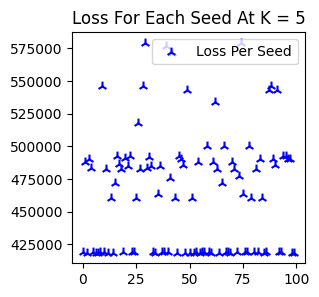

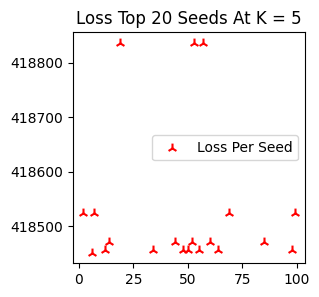

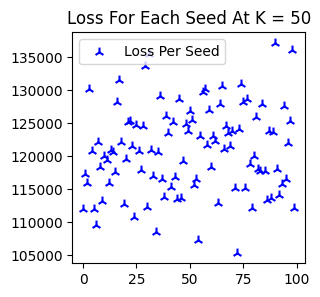

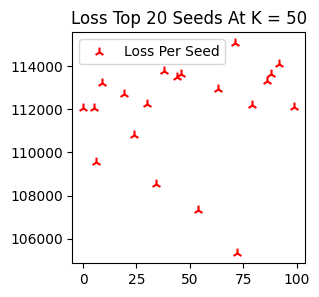

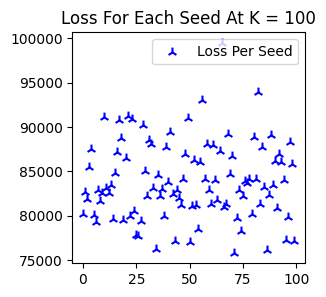

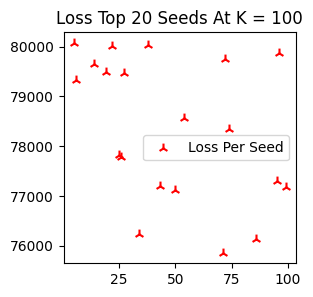

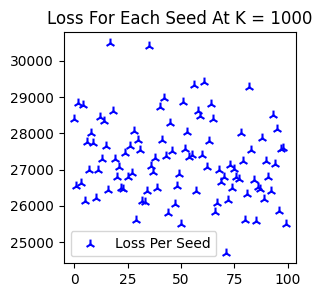

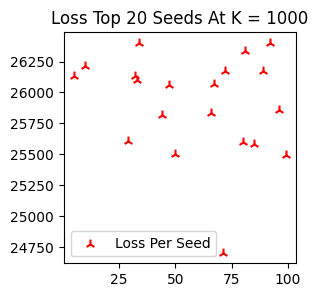

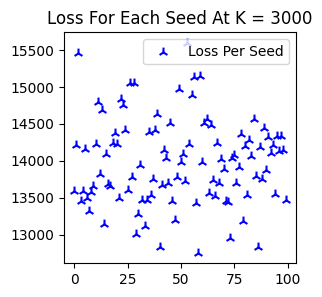

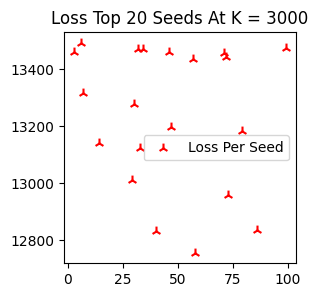

In [ ]:
print(k_all_seeds_resulting_loss)
# when we get all of our losses, we want to see the best ones by seed. so writing a quick algorithm to turn them into tuples, sort and display
best_20_seeds = [0] * 100
best_5_seeds = [0] * 100
best_seeds = []
for i in range(len(testing_seeds)):
  one_loss = k_all_seeds_resulting_loss[1 + i]
  loss_tuples = [[one_loss[j], j] for j in range(len(one_loss))]
  print(loss_tuples)
  loss_tuples.sort()
  print(' ')
  print(' ')

  print(f'k={testing_seeds[i]} top 10 best losses by seed : \n  {loss_tuples[0:10]}')
  loss_y = [x[0] for x in loss_tuples]
  loss_x = [x[1] for x in loss_tuples]

  loss_y_20 = [x[0] for x in loss_tuples[0:20]]
  loss_x_20 = [x[1] for x in loss_tuples[0:20]]
  for j in range(20):
    best_20_seeds[loss_tuples[j][1]] += 1
  for j in range(5):
    best_5_seeds[loss_tuples[j][1]] += 1
  best_seeds.append(loss_tuples[0][1])

  plt.figure(figsize = (3,3))
  plt.scatter(loss_x, loss_y, c='b', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss For Each Seed At K = {testing_seeds[i]}')
  plt.legend()

  plt.figure(figsize = (3,3))
  plt.scatter(loss_x_20, loss_y_20, c='r', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss Top 20 Seeds At K = {testing_seeds[i]}')
  plt.legend()

print(best_20_seeds) # top 20 seeds for each
print(best_5_seeds)
best_seeds = [(i, best_20_seeds[i]) for i in best_seeds]
print(best_seeds)

top_performing_seeds_3 =  [i for i in range(100) if best_20_seeds[i] > 2]
top_performing_seeds = [i for i in range(100) if best_20_seeds[i] > 3]
print('at least 3 in top 20', top_performing_seeds_3)
print('at least 4 in top 20', top_performing_seeds)

# Takeaways from first round of seed analysis

Initially I thought from looking at the scatter plot analysis that one seed always mega outperformed the others, but now I realize that cutting off the top 10 very much skews it that way.

There is some pretty steep dropoff after the top seed, after the top 10 seeds, after the top 15 seeds.
But what's interesting is when I thought to combine the BEST seed for each of the k counts (5, 50, 100, 1000, 3000), and how many times it appeared in each seed's top 20:
[(6, 4), (72, 4), (71, 4), (71, 4), (58, 1)]

every top seed appeared in all of the top 20s for every other count.
and if you look at the seeds that had at least 4 in top 20 [6, 34, 71, 72, 99], all of them were one of the best performing seeds except for 99.

I think what this says is two things:
1. clearly 58 should not be considered in the same regard as the others, and that 3000 is not worth considering for this kind of analysis, because 3000 is way overfit.
2. the cream really does rise to the top, so to speak. The seeds perform consistently across the different numbers of k.

So let's run almost the same analysis, bringing it down from 20 to 15 and cutting out the overfit 3000 category

[0, [419172.9827091642, 487646.6935471016, 418524.0780833028, 490361.21358869656, 483086.1937544782, 419173.273448657, 418450.73017169686, 418524.0780833028, 419172.9827091642, 546034.9327977502, 418847.42041198665, 482968.4641164818, 418455.05430107086, 460141.8133333587, 418470.6702219375, 471756.5505504194, 492644.3030546893, 486377.93796340196, 482968.4641164818, 418836.8765015681, 491104.01826183806, 484625.7418876089, 492635.9868401213, 418968.56350215466, 419172.9827091642, 460141.8133333587, 517793.9499013043, 482968.4641164818, 545982.0954690088, 579324.5023479913, 483086.1937544782, 491695.7677946387, 484625.7418876089, 419172.9827091642, 418455.05430107086, 463827.31410387706, 484758.4999835273, 418847.42041198665, 419172.9827091642, 576598.9519242783, 419049.44202488137, 475848.7386105268, 571841.6409785782, 460284.9784745275, 418470.6702219375, 492635.9868401213, 490136.4841745552, 485791.2844599582, 418455.05430107086, 543377.8226197624, 418455.05430107086, 460062.0602918

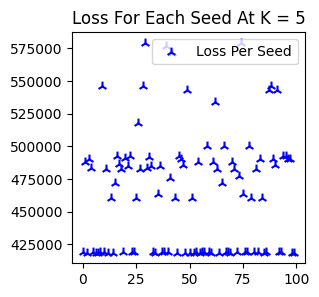

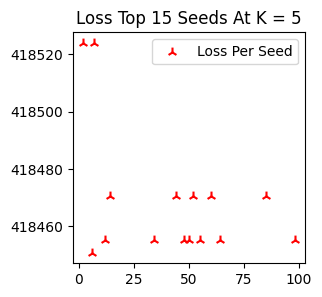

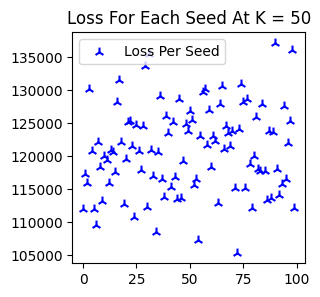

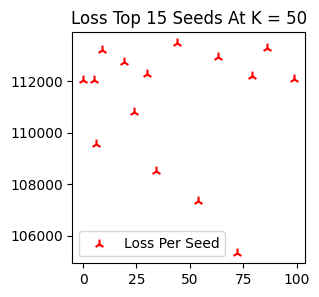

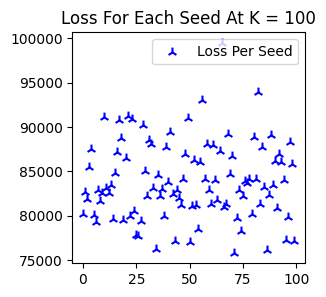

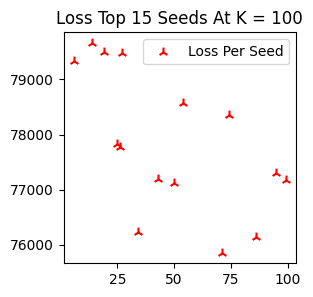

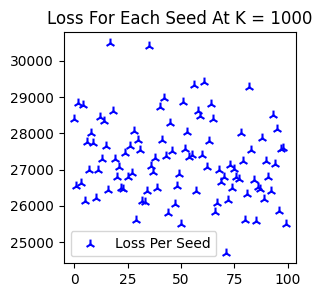

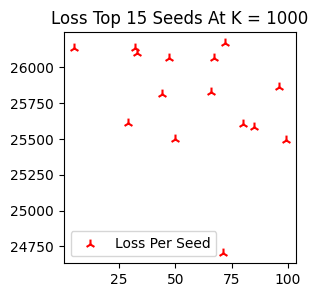

In [ ]:
print(k_all_seeds_resulting_loss)
# when we get all of our losses, we want to see the best ones by seed. so writing a quick algorithm to turn them into tuples, sort and display
best_15_seeds = [0] * 100
best_5_seeds = [0] * 100
best_seeds = []
for i in range(len(testing_seeds) - 1): # ignore 3000
  one_loss = k_all_seeds_resulting_loss[1 + i]
  loss_tuples = [[one_loss[j], j] for j in range(len(one_loss))]
  print(loss_tuples)
  loss_tuples.sort()
  print(' ')
  print(' ')

  print(f'k={testing_seeds[i]} top 10 best losses by seed : \n  {loss_tuples[0:10]}')
  loss_y = [x[0] for x in loss_tuples]
  loss_x = [x[1] for x in loss_tuples]

  loss_y_15 = [x[0] for x in loss_tuples[0:15]]
  loss_x_15 = [x[1] for x in loss_tuples[0:15]]
  for j in range(15):
    best_15_seeds[loss_tuples[j][1]] += 1
  for j in range(5):
    best_5_seeds[loss_tuples[j][1]] += 1
  best_seeds.append(loss_tuples[0][1])

  plt.figure(figsize = (3,3))
  plt.scatter(loss_x, loss_y, c='b', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss For Each Seed At K = {testing_seeds[i]}')
  plt.legend()

  plt.figure(figsize = (3,3))
  plt.scatter(loss_x_15, loss_y_15, c='r', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss Top 15 Seeds At K = {testing_seeds[i]}')
  plt.legend()

print(best_15_seeds) # top 15 seeds for each
print(best_5_seeds)
best_seeds = [(i, best_15_seeds[i]) for i in best_seeds]
print(best_seeds)

top_performing_seeds_3 =  [i for i in range(100) if best_15_seeds[i] > 1]
top_performing_seeds = [i for i in range(100) if best_15_seeds[i] > 2]
print('at least 2 in top 15', top_performing_seeds_3)
print('at least 3 in top 15', top_performing_seeds)

at least 2 in top 15 [5, 6, 14, 19, 34, 44, 50, 54, 71, 72, 85, 86, 99]

at least 3 in top 15 [6, 34, 44, 50, 99]

comparing that to our old data
at least 3 in top 20 [5, 6, 14, 19, 34, 44, 50, 71, 72, 86, 99]
at least 4 in top 20 [6, 34, 71, 72, 99]

here are my takeaways from this - there are 13 seeds with overlap when you look at the top 15


there are 6 with at least 3 in the top 15 of each seed.

I think that while you would want to assume that means we can comfortably select these as our top performing seeds, and move forward with those lists, it noticeably does not contain seeds 71 and 72 - which were the PURE minima of three k counts.


In [ ]:
result_seeds = [[5, 6, 14, 19, 34, 44, 50, 54, 71, 72, 85, 86, 99], [6, 34, 44, 50, 99], [5, 6, 14, 19, 34, 44, 50, 71, 72, 86, 99], [6, 34, 71, 72, 99]]

best_seed_set = set()
for seed_list in result_seeds:
  for seed in seed_list:
    best_seed_set.add(seed)

print(sorted(list(best_seed_set)), len(best_seed_set))

[5, 6, 14, 19, 34, 44, 50, 54, 71, 72, 85, 86, 99] 13


In [ ]:
# one last check, I just want to see how many just didn't have 0
non_zero_seeds = [(i, best_15_seeds[i]) for i in range(100) if best_15_seeds[i] > 0]
print(non_zero_seeds, len(non_zero_seeds))
# 42
better_one_seeds = [(i, best_15_seeds[i]) for i in range(100) if best_15_seeds[i] > 1]
print(better_one_seeds, len(better_one_seeds))

[(0, 1), (2, 1), (5, 2), (6, 3), (7, 1), (9, 1), (12, 1), (14, 2), (19, 2), (24, 1), (25, 1), (26, 1), (27, 1), (29, 1), (30, 1), (32, 1), (33, 1), (34, 3), (43, 1), (44, 3), (47, 1), (48, 1), (50, 3), (52, 1), (54, 2), (55, 1), (60, 1), (63, 1), (64, 1), (66, 1), (67, 1), (71, 2), (72, 2), (74, 1), (79, 1), (80, 1), (85, 2), (86, 2), (95, 1), (96, 1), (98, 1), (99, 3)] 42
[(5, 2), (6, 3), (14, 2), (19, 2), (34, 3), (44, 3), (50, 3), (54, 2), (71, 2), (72, 2), (85, 2), (86, 2), (99, 3)] 13


In [ ]:
# final set
for seed, count in better_one_seeds:
  best_seed_set.add(seed)

print(sorted(list(best_seed_set)), len(best_seed_set))

[5, 6, 14, 19, 34, 44, 50, 54, 71, 72, 85, 86, 99] 13


it seems that our top 15 seeds for [5, 50, 100, 1000] (excluding 3000), reduced to ones that had at least 2 seeds show up as local minima, had a full overlap with the best seed set.
I thought this would add like one or two more to the list, but it did not at all.
So this is our seed set. it's good to go.

[5, 6, 14, 19, 34, 44, 50, 54, 71, 72, 85, 86, 99] 13

Like I said, maybe I'll run through seeds 100-200 to check those out and get up to like 20, or improve to 15 better ones, but we might have it here. Plus 5 seeds makes about 3 mins per with this data set, so we're looking at 10 minutes per k which would be 15000 minutes, which is 250 hours, which is like 12 days of running data that obviously won't work.


ok nevermind now that I've put it like that let's reassess our top seeds and only take the best of the best

In [ ]:
real_best_seeds = set()
top_seeds = [[6, 34, 44, 50, 99], [6, 34, 71, 72, 99]]
for t_s in top_seeds:
  for seed in t_s:
    real_best_seeds.add(seed)

print(sorted(list(real_best_seeds)), len(real_best_seeds))

[6, 34, 44, 50, 71, 72, 99] 7


[6, 34, 44, 50, 71, 72, 99] 7

7 should be much more manageable. Should be about 4 minutes per k.
4 minutes * 1500 k = 6000/60 = 100/24 = 4.16 days

So this raises the question - where will our elbow lie?
Hopefully it won't be necessary to go all the way to 1500.
What is the spot? 500? 750? 1000? those are days of difference lol
Could it be as low as 100? 250?


In [ ]:
# refresh our global variables, we don't need a 0 placeholder because indices will not correlate with k
k_best_seeds = []
k_losses = []
k_best_init_centroids = []
k_best_final_centroids = []
k_all_seeds_resulting_loss = []
k_best_centroid_count = []

seeds = sorted(list(real_best_seeds))
ks = [5, 10, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000, 2500] # with 15 ks at 4 minutes a piece this should take an hour
for k in ks:
  k_means(k, seeds)

Output hidden; open in https://colab.research.google.com to view.

[tensor(418450.7302, dtype=torch.float64), tensor(276873.1900, dtype=torch.float64), tensor(147370.3028, dtype=torch.float64), tensor(105339.6066, dtype=torch.float64), tensor(75857.9355, dtype=torch.float64), tensor(52870.5116, dtype=torch.float64), tensor(44323.3341, dtype=torch.float64), tensor(39532.6718, dtype=torch.float64), tensor(34971.3942, dtype=torch.float64), tensor(29222.6290, dtype=torch.float64), tensor(24706.1452, dtype=torch.float64), tensor(22283.6877, dtype=torch.float64), tensor(20614.6143, dtype=torch.float64), tensor(17086.7939, dtype=torch.float64), tensor(14979.1589, dtype=torch.float64)]


Text(0, 0.5, 'Loss')

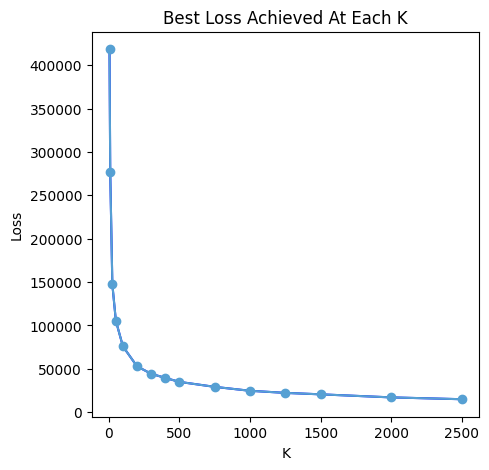

In [85]:
# and then after running our k_means I want to visualize the loss per k
print(k_losses)
plt.figure(figsize = (5,5))
plt.plot(ks, k_losses, c='b', label='Best Loss For K')
plt.plot(ks, k_losses, c='#56a0d3', marker='o', label='Best Loss For K')
plt.title(f'Best Loss Achieved At Each K')
plt.xlabel('K')
plt.ylabel('Loss')

In [86]:
# let's try saving one of these pytorch models
from google.colab import drive
drive.mount('/content/gdrive')

kmeans_model = [k_best_seeds, k_losses, k_best_init_centroids, k_best_final_centroids, k_all_seeds_resulting_loss, k_best_centroid_count]

torch.save(kmeans_model, '/content/gdrive/My Drive/Colab Notebooks/elbow_projection.pth')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


That is some great news! The elbow chart clearly shows that our optimal k is somewhere around 250.

Not coincidentally, I did some researching on how many cities there are in the United States, and the internet says that there are 336 incorporated places in the US with populations of at least 100,000.
https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

So I believe that 350 will be my new cap for how many I will create for the final visualization, because I want to go a little past the elbow for sure.
350 * 4 = 1400 / 60 = 23.33 hours, so just under a day to create that.
350 * 3 = 1050 / 60 = 17.5 hours, so somewhere in between there.

before starting the final model though, I'm going to rerun the elbow projection to get a better approximation on where it will be.
I want to assess some slightly different points though with good coverage of the range from 25 to 500 this time
ks = [33, 66, 99, 133, 166, 215, 265, 315, 365, 415, 465, 515]

In [87]:
%%timeit
# refresh our global variables, we don't need a 0 placeholder because indices will not correlate with k
k_best_seeds = []
k_losses = []
k_best_init_centroids = []
k_best_final_centroids = []
k_all_seeds_resulting_loss = []
k_best_centroid_count = []

seeds = sorted(list(real_best_seeds))
ks = [33, 66, 99, 133, 166, 215, 265, 315, 365, 415, 465, 515] # with 12 ks at 3.5 minutes a piece this should take 45min
for k in ks:
  k_means(k, seeds)

Output hidden; open in https://colab.research.google.com to view.

I don't know why my training loop started over at 33 after going through all the ks, but it made me do some manual review of the data.

for
ks = [33, 66, 99, 133, 166, 215, 265, 315, 365, 415, 465, 515]

using seeds = [6, 34, 44, 50, 71, 72, 99]

the dominantly useful seed was 71, which was the optimal seed for k [133, 166, 215, 265, 315, 365, 415, 465, 515]

This covers the entire elbow range, which is good for use, we do not need to test the other seeds to check for local minima

seed 34 was optimal for k 33, 99
and seed 99 was optimal for k 66 (but 34 was in second)

That means for this data, we only need to use

[ seed 6 for k 1-20]

[ seed 34 for 21-110]

[ seed 71 for 111-350]


however, I'd like to check closer to the elbow and make sure that there aren't any better seeds from 100-250, compared to 71.

But first, let's see our elbow

[126217.87902252587, 92043.88050913974, 76386.13384644367, 65022.37840020279, 58656.26777823102, 50437.67008892707, 47949.6585085856, 43824.5040874565, 40494.004907942726, 39096.44155521129, 35847.3050296079, 34318.47820323812]


Text(0, 0.5, 'Loss')

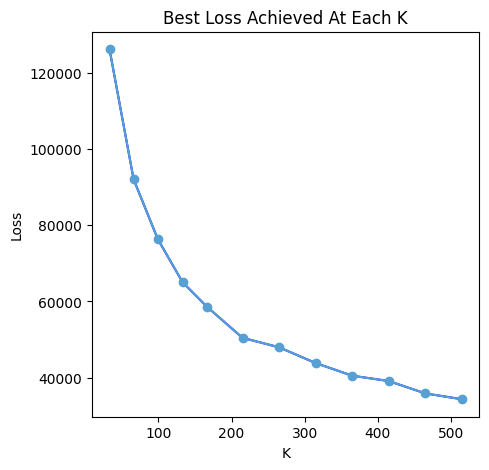

In [90]:
# i don't know why that loop started running over again, but i'm not waiting another hour lmao.

ks = [33, 66, 99, 133, 166, 215, 265, 315, 365, 415, 465, 515]
k_losses = [126217.87902252587, 92043.88050913974, 76386.13384644367, 65022.37840020279, 58656.26777823102, 50437.67008892707, 47949.6585085856, 43824.5040874565, 40494.004907942726, 39096.44155521129, 35847.3050296079, 34318.47820323812]

# and then after running our k_means I want to visualize the loss per k

print(k_losses)
plt.figure(figsize = (5,5))
plt.plot(ks, k_losses, c='b', label='Best Loss For K')
plt.plot(ks, k_losses, c='#56a0d3', marker='o', label='Best Loss For K')
plt.title(f'Best Loss Achieved At Each K')
plt.xlabel('K')
plt.ylabel('Loss')

In [89]:
# let's try saving one of these pytorch models
from google.colab import drive
drive.mount('/content/gdrive')

kmeans_model = [k_best_seeds, k_losses, k_best_init_centroids, k_best_final_centroids, k_all_seeds_resulting_loss, k_best_centroid_count]

torch.save(kmeans_model, '/content/gdrive/My Drive/Colab Notebooks/elbow_projection_zoom.pth')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Beginning Seed 71 for k_means 225
  wloop 0 - cur loss: 116240.07028649752, prev loss: None
  wloop 1 - cur loss: 65267.08912824252, prev loss: 116240.07028649752
  wloop 2 - cur loss: 57957.0889572247, prev loss: 65267.08912824252
  wloop 3 - cur loss: 54891.80545970266, prev loss: 57957.0889572247
  wloop 4 - cur loss: 53325.065672064025, prev loss: 54891.80545970266
  wloop 5 - cur loss: 52611.06932093355, prev loss: 53325.065672064025
  wloop 6 - cur loss: 52301.09205507483, prev loss: 52611.06932093355
  wloop 7 - cur loss: 52018.54200274005, prev loss: 52301.09205507483
  wloop 8 - cur loss: 51771.81214021096, prev loss: 52018.54200274005
  wloop 9 - cur loss: 51497.61085950887, prev loss: 51771.81214021096
  wloop 10 - cur loss: 50944.40686890129, prev loss: 51497.61085950887
  wloop 11 - cur loss: 50080.24491198303, prev loss: 50944.40686890129
  wloop 12 - cur loss: 49806.28176205676, prev loss: 50080.24491198303
  wloop 13 - cur loss: 49751.663065878805, prev loss: 49806.2817

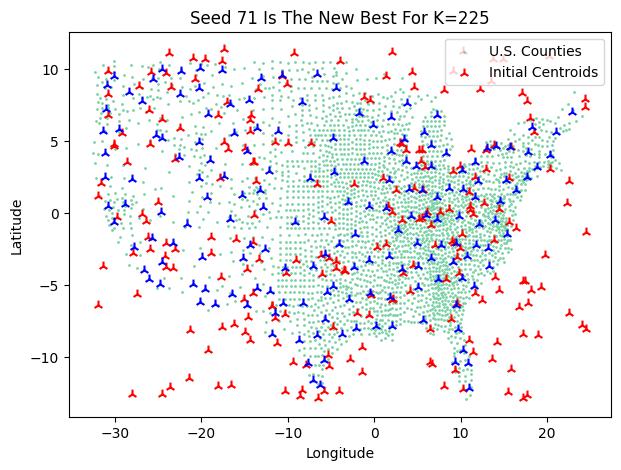

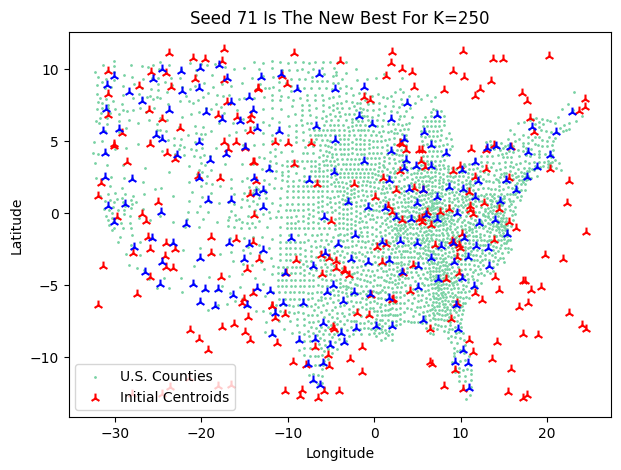

In [100]:
# the K point at 265 looks a little off, so I want to check 225 and 250 before I can call it for sure
# but now we know for sure that 71 is the best seed to use
ks = [225, 250]
seeds = [71]

for k in ks:
  k_means(k, seeds)

Text(0, 0.5, 'Loss')

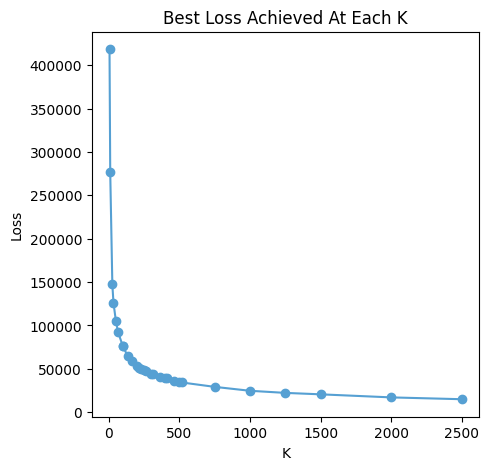

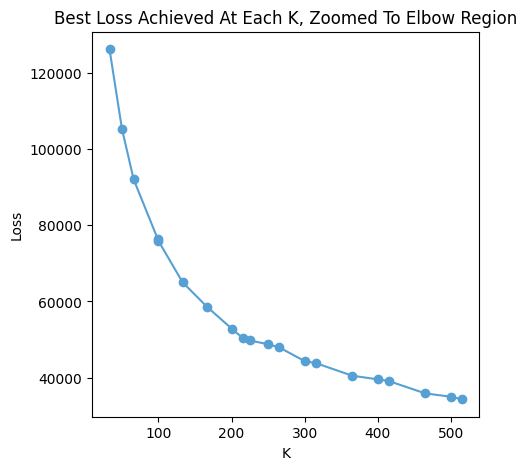

In [102]:
# instead of just guessing at where the elbow point is we can actually combine the data from these two runs to get a better look
first_elbow_k = [5, 10, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000, 2500]
first_elbow_loss = [418450.7302, 276873.1900, 147370.3028, 105339.6066, 75857.9355, 52870.5116, 44323.3341, 39532.6718, 34971.3942, 29222.6290, 24706.1452, 22283.6877, 20614.6143, 17086.7939, 14979.1589]
second_elbow_k = [33, 66, 99, 133, 166, 215, 265, 315, 365, 415, 465, 515]
second_elbow_loss = [126217.87902252587, 92043.88050913974, 76386.13384644367, 65022.37840020279, 58656.26777823102, 50437.67008892707, 47949.6585085856, 43824.5040874565, 40494.004907942726, 39096.44155521129, 35847.3050296079, 34318.47820323812]
third_elbow_k = [225, 250]
third_elbow_loss = [49755.80623084859, 48741.92197939386]

combined_k = sorted(first_elbow_k + second_elbow_k + third_elbow_k)
combined_loss = sorted(first_elbow_loss + second_elbow_loss + third_elbow_loss, reverse = True)

first_relevant_k = first_elbow_k[3 : 9]
first_relevant_loss = first_elbow_loss[3 : 9]

zoom_k = sorted(second_elbow_k + first_relevant_k + third_elbow_k)
zoom_loss = sorted(second_elbow_loss + first_relevant_loss + third_elbow_loss, reverse = True)

plt.figure(figsize = (5,5))
plt.plot(combined_k, combined_loss, c='#56a0d3', marker='o', linestyle='-', label='Best Loss For K')
plt.title(f'Best Loss Achieved At Each K')
plt.xlabel('K')
plt.ylabel('Loss')


plt.figure(figsize = (5,5))
plt.plot(zoom_k, zoom_loss, c='#56a0d3', marker='o', linestyle='-', label='Best Loss For K')
plt.title(f'Best Loss Achieved At Each K, Zoomed To Elbow Region')
plt.xlabel('K')
plt.ylabel('Loss')


With our data combined as such, it's pretty clear to see that the slope drops off dramatically after k = 215. That is very clearly the elbow point. I am going to use k=225 because it's the first point to make it under a loss of 50000.

I also learned that the %%timeit will run your code literally a million times, and the flag -n doesn't seem to work with 1, it'll probably try to run 100 times. So that's not a function that I should be using here. Glad I figured that one out before a big run.

Creating our finalized model will be from one single seed, because 71 served as the true minimum for everything between k = 133 to k = 515.
That covers all of the points around our elbow region.

Instead of simply using
[ seed 6 for k 1-10]
[ seed 34 for k 11-110] and
[ seed 71 for k 111-350],

I want to test some more seeds for both of these regions.

I will test k=69 for seeds 100-250 + 34

and I will test k=225 for seeds 100-250 + 71

and I will test k=10 for seeds 100-250 + 6

This will produce three truly optimal seeds we can base our final model on.

Beginning Seed 6 for k_means 7
  wloop 0 - cur loss: 745766.060058054, prev loss: None
  wloop 1 - cur loss: 433174.7263637893, prev loss: 745766.060058054
  wloop 2 - cur loss: 401844.5298739445, prev loss: 433174.7263637893
  wloop 3 - cur loss: 388201.16563836334, prev loss: 401844.5298739445
  wloop 4 - cur loss: 372915.1095439902, prev loss: 388201.16563836334
  wloop 5 - cur loss: 367016.30696856347, prev loss: 372915.1095439902
  wloop 6 - cur loss: 365772.6821818697, prev loss: 367016.30696856347
  wloop 7 - cur loss: 365304.6785714518, prev loss: 365772.6821818697
  wloop 8 - cur loss: 365224.5497854032, prev loss: 365304.6785714518
  wloop 9 - cur loss: 365148.3664587082, prev loss: 365224.5497854032
  wloop 10 - cur loss: 364604.1185982029, prev loss: 365148.3664587082
  wloop 11 - cur loss: 364782.5698881175, prev loss: 364604.1185982029
  wloop 12 - cur loss: 364188.1208813355, prev loss: 364782.5698881175
  wloop 13 - cur loss: 364292.8118519606, prev loss: 364188.1208813

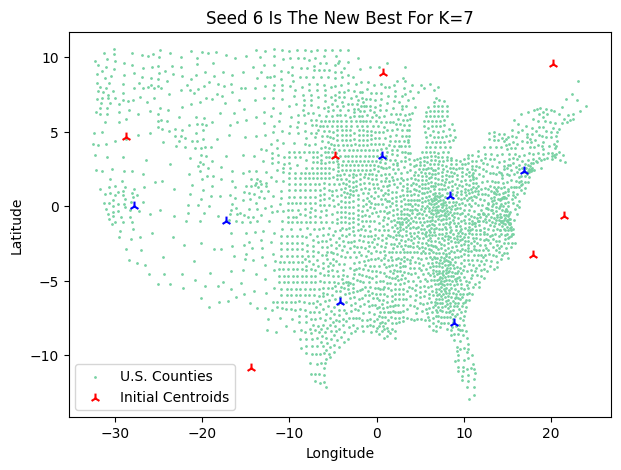

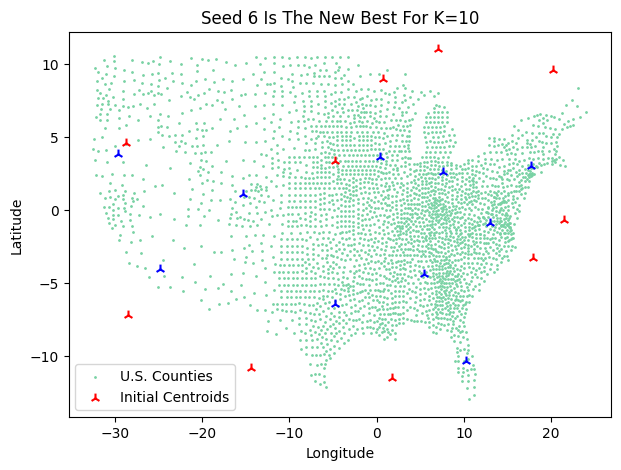

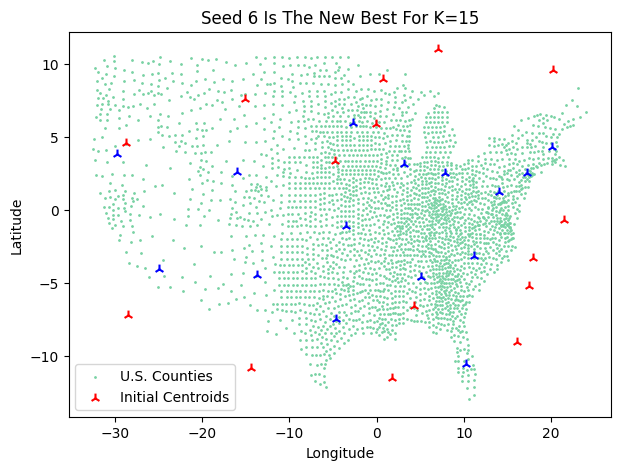

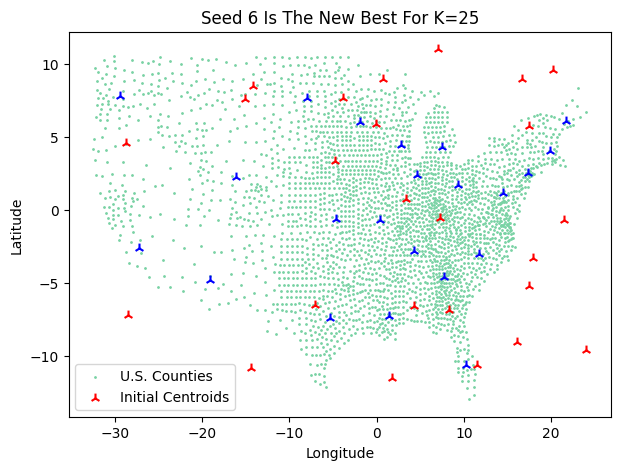

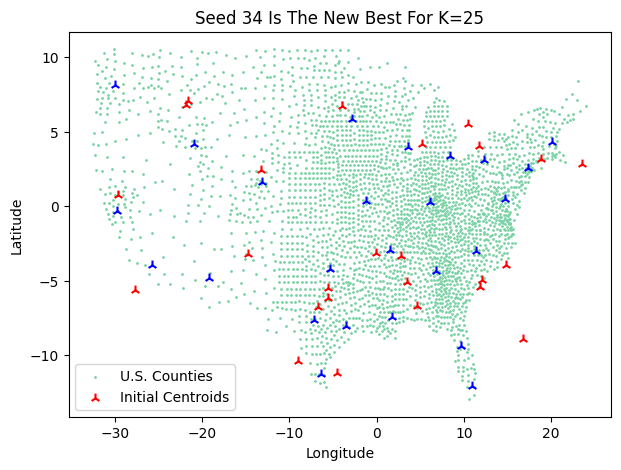

In [103]:
one_last_check = [7, 10, 15, 25]
seeds = [6, 34]

k_best_seeds = []
k_losses = []
k_best_init_centroids = []
k_best_final_centroids = []
k_all_seeds_resulting_loss = []
k_best_centroid_count = []

for k in one_last_check:
  k_means(k, seeds)

I wanted to do that check to check the actual difference in loss between seed 6 and seed 34 at the lowest values of k, and observe when 34 becomes the better seed.

It is not until k = 25 that seed 34 becomes a better seed than seed 6.

HOWEVER, the difference in loss is only 1000 for each of these, when the total loss is in the multiple hundreds of thousands, and is thus negligible. Because seed 34 creates an approximate minimum, I will only run two checks.

To refine what I was writing in the previous text, I will use:

[ seed 34 for k 1-110] and [ seed 71 for k 111-350],

I will test k=69 for seeds 100-250 + 34

and I will test k=225 for seeds 100-250 + 71

In [ ]:
more_seed_checking = [69, 225]
r = [i for i in range(100, 251)]
r_69 = r + [34]
r_225 = r + [71]
idx_69 = [i for i in range(100, 251)]
idx_69.append(34)
idx_225 = [i for i in range(100, 251)]
idx_225.append(71)
idx = idx_69 + idx_225

k_best_seeds = []
k_losses = []
k_best_init_centroids = []
k_best_final_centroids = []
k_all_seeds_resulting_loss = []
k_best_centroid_count = []

k_means(69, r_69)
k_means(225, r_225)

In [ ]:
# copying our seed analysis from earlier
print(k_all_seeds_resulting_loss)
# when we get all of our losses, we want to see the best ones by seed. so writing a quick algorithm to turn them into tuples, sort and display
seeds_checked = len(r_69)
best_20_seeds = [0] * 100
best_5_seeds = [0] * 100
best_seeds = []
for k in range(2): # checking 2 seeds
  one_loss = k_all_seeds_resulting_loss[1 + i]

  loss_tuples = []
  for j in range(seeds_checked):
    loss_tuples.append(one_loss[j], idx[k][j])
  print(loss_tuples)
  loss_tuples.sort()
  print(' ')
  print(' ')

  print(f'k={more_seed_checking[k]} top 10 best losses by seed : \n  {loss_tuples[0:10]}')
  loss_y = [x[0] for x in loss_tuples]
  loss_x = [x[1] for x in loss_tuples]

  loss_y_20 = [x[0] for x in loss_tuples[0:20]]
  loss_x_20 = [x[1] for x in loss_tuples[0:20]]
  for j in range(20):
    best_20_seeds[loss_tuples[j][1]] += 1
  for j in range(5):
    best_5_seeds[loss_tuples[j][1]] += 1
  best_seeds.append(loss_tuples[0][1])

  plt.figure(figsize = (3,3))
  plt.scatter(loss_x, loss_y, c='b', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss For Each Seed At K = {testing_seeds[i]}')
  plt.legend()

  plt.figure(figsize = (3,3))
  plt.scatter(loss_x_20, loss_y_20, c='r', s=50, marker='2', label='Loss Per Seed')
  plt.title(f'Loss Top 20 Seeds At K = {testing_seeds[i]}')
  plt.legend()

print(best_20_seeds) # top 20 seeds for each
print(best_5_seeds)
best_seeds = [(i, best_20_seeds[i]) for i in best_seeds]
print(best_seeds)

top_performing_seeds = [i for i in range(seeds_checked) if best_20_seeds[i] > 1]
print('at least 4 in top 20', top_performing_seeds)